In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_swiss_roll

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
x, _ = make_swiss_roll(n_samples=50000, noise=0.5)
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std()

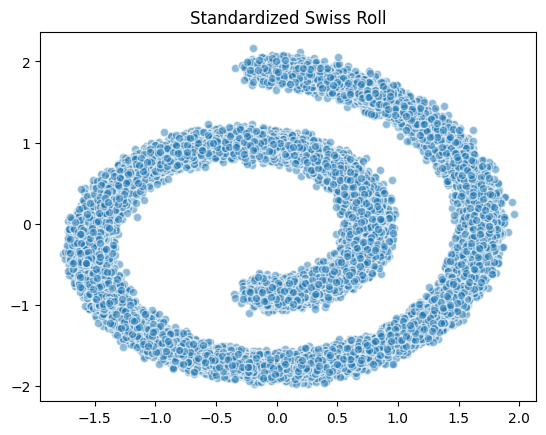

In [4]:
sns.scatterplot(x=x[:, 0], y=x[:, 1], alpha=0.5, edgecolor="white", linewidth=1)

plt.title("Standardized Swiss Roll")
plt.show()

### Datasets


In [5]:
class SamplesDataset(Dataset):
    def __init__(self, X):
        self.X = X
        self.N_samples = X.shape[0]
        self.dimension = X.shape[1]

    def __len__(self):
        return self.N_samples

    def __getitem__(self, idx):
        return self.X[idx, :]


class DiffusionDataset(Dataset):
    def __init__(self, samples_ds, T, alpha, alpha_bar, beta):
        self.samples_ds = samples_ds
        self.T = T
        self.alpha = alpha
        self.alpha_bar = alpha_bar
        self.beta = beta

    def __len__(self):
        return len(self.samples_ds)

    def noise(self, Xbatch, t):
        t_index = t.long().view(-1)  # Ensure t is a 1D long tensor
        alpha_t = torch.gather(
            self.alpha_bar, 0, t_index
        )  # Gather corresponding alphas

        # Make sure alpha_t is a 1D tensor
        if alpha_t.ndim == 0:
            alpha_t = alpha_t.unsqueeze(0)

        eps = torch.randn_like(Xbatch)

        # Apply the noise
        noised = (alpha_t**0.5).unsqueeze(1) * Xbatch + (
            (1 - alpha_t) ** 0.5
        ).unsqueeze(1) * eps
        return noised, eps

    def __getitem__(self, idx):
        # Randomly choose a time step for each sample
        t = torch.randint(0, self.T, (1,)).long()

        # Retrieve the data sample
        x0 = self.samples_ds[idx]

        # Ensure x0 is a float tensor and add an extra dimension if necessary
        if not isinstance(x0, torch.Tensor):
            x0 = torch.tensor(x0, dtype=torch.float32)
        if x0.ndim == 1:
            x0 = x0.unsqueeze(0)

        # Apply noise to the data sample
        xt, eps = self.noise(x0, t)

        # Return the noised data, time step, and actual noise
        return xt.squeeze(0), t.squeeze(), eps.squeeze(0)

### DataLoaders


In [6]:
def torch_collate(batch):
    # Assuming each element in batch is a tuple (xt, t, eps)
    if isinstance(batch[0], torch.Tensor):
        return torch.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        return [torch_collate(samples) for samples in zip(*batch)]
    else:
        raise TypeError("Batch must contain torch tensors or tuples/lists")

In [7]:
# diffusion_steps = 40
# beta_start = 1e-4
# beta_end = 0.02

# beta = torch.linspace(beta_start, beta_end, diffusion_steps)
# alpha = 1 - beta
# alpha_bar = torch.cumprod(alpha, dim=0)


#  better cosine noise schedule setup
diffusion_steps = 40
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2) ** 2

alpha_bar = schedule / schedule[0]
beta = 1 - alpha_bar / torch.concatenate([alpha_bar[0:1], alpha_bar[0:-1]])
alpha = 1 - beta

In [8]:
samples_ds = SamplesDataset(x)
diff_ds = DiffusionDataset(samples_ds, 5, alpha, alpha_bar, beta)

diff_dl = DataLoader(diff_ds, batch_size=128, shuffle=True, collate_fn=torch_collate)

### Model


In [9]:
import torch.nn as nn
import torch.nn.functional as F


class DiffusionBlock(nn.Module):
    def __init__(self, n_units):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(n_units, n_units)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, dim: int, n_blocks: int = 2, n_units: int = 128):
        super(DiffusionModel, self).__init__()

        self.linearIn = nn.Linear(dim + 1, n_units)
        self.blocksSeq = nn.ModuleList(
            [DiffusionBlock(n_units) for _ in range(n_blocks)]
        )
        self.linearOut = nn.Linear(n_units, dim)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        if t.ndim == 1:
            t = t.unsqueeze(1)
        elif t.ndim > 2:
            raise ValueError("Time step tensor t has more than 2 dimensions")

        val = torch.hstack([x, t])
        val = self.linearIn(val)
        for blockSeq in self.blocksSeq:
            val = blockSeq(val)
        val = self.linearOut(val)
        return val

### Sampling


In [10]:
class Sampler:
    def __init__(self, diff_ds, gamma, predictor_step, step_size=None):
        self.diff_ds = diff_ds
        self.gamma = gamma
        self.predictor_step = predictor_step
        self.step_size = step_size if step_size is not None else gamma

    def DDPMSampling(self, model, nsamples, nfeatures):
        with torch.no_grad():
            x = torch.randn(size=(nsamples, nfeatures))
            diffusion_steps = self.diff_ds.T
            alphas = self.diff_ds.alpha
            alpha_bars = self.diff_ds.alpha_bar
            betas = self.diff_ds.beta

            for t in range(diffusion_steps - 1, 0, -1):
                predicted_noise = model(
                    x, torch.full([nsamples, 1], t, dtype=torch.float32)
                )
                x = (
                    1
                    / (alphas[t] ** 0.5)
                    * (
                        x
                        - (1 - alphas[t])
                        / ((1 - alpha_bars[t]) ** 0.5)
                        * predicted_noise
                    )
                )
                if t > 1:
                    variance = betas[t]
                    std = variance ** (0.5)
                    x += std * torch.randn(size=(nsamples, nfeatures))
            return x

    # def EulerMaruyamaSampling(
    #     self, model, y0, log_freq=0.1, store_intermediate_samples=False
    # ):
    #     gamma_tensor = torch.tensor(self.gamma)
    #     T = self.diff_ds.T
    #     N_langevin = int(T / self.gamma)
    #     intermediate_samples = []

    #     y = y0
    #     t = torch.zeros(y0.size(0), 1) + T

    #     for k in range(N_langevin):
    #         t -= gamma_tensor
    #         z = torch.randn_like(y)
    #         y = (
    #             y
    #             + gamma_tensor * y
    #             + 2 * gamma_tensor * model(t, y)
    #             + torch.sqrt(2 * gamma_tensor) * z
    #         )
    #         for _ in range(self.predictor_step):
    #             z = torch.randn_like(y)
    #             y = y + gamma_tensor * model(t, y) + torch.sqrt(2 * gamma_tensor) * z
    #         if store_intermediate_samples and (k % int(N_langevin / log_freq) == 0):
    #             intermediate_samples.append(y.clone().detach())

    #     if store_intermediate_samples:
    #         return intermediate_samples
    #     else:
    #         return y

### Training


In [11]:
model = DiffusionModel(dim=2, n_blocks=8)
model = model.to(device)

In [12]:
def plot_samples(samples, epoch):
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=samples[:, 0], y=samples[:, 1], alpha=0.5, edgecolor="white", linewidth=1
    )
    plt.axis("off")
    plt.title(f"Samples at Epoch {epoch}")
    plt.show()
    plt.close()

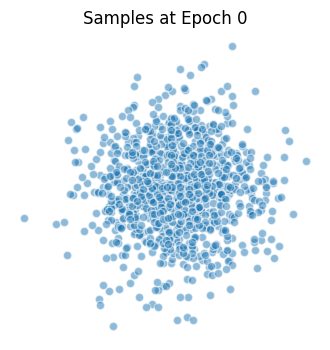

Epoch 0, Loss: 0.9759296178817749
Epoch 1, Loss: 1.101275086402893
Epoch 2, Loss: 0.8613832592964172
Epoch 3, Loss: 0.9611498117446899
Epoch 4, Loss: 0.7244204878807068
Epoch 5, Loss: 0.9245001077651978
Epoch 6, Loss: 0.9184097051620483
Epoch 7, Loss: 1.119795322418213
Epoch 8, Loss: 0.6273094415664673
Epoch 9, Loss: 0.6766129732131958
Epoch 10, Loss: 0.9445692300796509
Epoch 11, Loss: 0.7683405876159668
Epoch 12, Loss: 1.027622103691101
Epoch 13, Loss: 0.7961927056312561
Epoch 14, Loss: 0.8869331479072571
Epoch 15, Loss: 0.792286217212677
Epoch 16, Loss: 0.6215837597846985
Epoch 17, Loss: 0.8346947431564331
Epoch 18, Loss: 0.7727643251419067
Epoch 19, Loss: 0.9158482551574707
Epoch 20, Loss: 0.6402415037155151
Epoch 21, Loss: 0.7376499176025391
Epoch 22, Loss: 0.855392336845398
Epoch 23, Loss: 0.6991316676139832
Epoch 24, Loss: 0.8137070536613464
Epoch 25, Loss: 0.6430225372314453
Epoch 26, Loss: 0.6545851826667786
Epoch 27, Loss: 0.9100050926208496
Epoch 28, Loss: 0.83466637134552
Ep

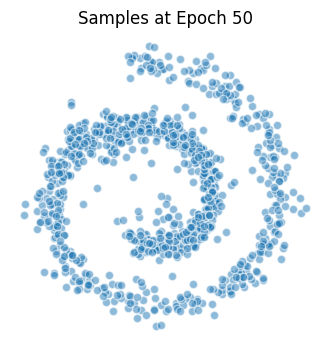

Epoch 50, Loss: 0.5836290121078491
Epoch 51, Loss: 0.5804632902145386
Epoch 52, Loss: 0.9011749029159546
Epoch 53, Loss: 1.0222307443618774
Epoch 54, Loss: 0.7038888931274414
Epoch 55, Loss: 0.983448326587677
Epoch 56, Loss: 0.7977070212364197
Epoch 57, Loss: 0.6967968940734863
Epoch 58, Loss: 0.6322083473205566
Epoch 59, Loss: 0.7391277551651001
Epoch 60, Loss: 0.6864559650421143
Epoch 61, Loss: 0.9979952573776245
Epoch 62, Loss: 0.8191524744033813
Epoch 63, Loss: 0.7913795113563538
Epoch 64, Loss: 0.8035858869552612
Epoch 65, Loss: 0.6511352062225342
Epoch 66, Loss: 0.7937918901443481
Epoch 67, Loss: 0.7497578859329224
Epoch 68, Loss: 0.6323139071464539
Epoch 69, Loss: 0.8484188318252563
Epoch 70, Loss: 0.594667375087738
Epoch 71, Loss: 0.7358778715133667
Epoch 72, Loss: 0.6733734607696533
Epoch 73, Loss: 0.8758367300033569
Epoch 74, Loss: 0.7439175248146057
Epoch 75, Loss: 0.8779271245002747
Epoch 76, Loss: 0.6175433993339539
Epoch 77, Loss: 0.8589261174201965
Epoch 78, Loss: 0.7360

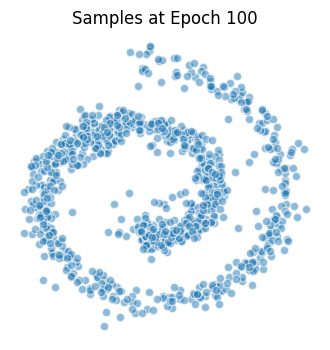

Epoch 100, Loss: 0.8906672596931458
Epoch 101, Loss: 0.8526709675788879
Epoch 102, Loss: 0.7655376195907593
Epoch 103, Loss: 0.8235630989074707
Epoch 104, Loss: 0.5332371592521667
Epoch 105, Loss: 0.6742768287658691
Epoch 106, Loss: 1.008655071258545
Epoch 107, Loss: 0.7678980827331543
Epoch 108, Loss: 0.8107209205627441
Epoch 109, Loss: 1.1382287740707397
Epoch 110, Loss: 0.7313847541809082
Epoch 111, Loss: 0.8982850909233093
Epoch 112, Loss: 0.7146031260490417
Epoch 113, Loss: 0.6952947378158569
Epoch 114, Loss: 0.7138654589653015
Epoch 115, Loss: 0.7498618364334106
Epoch 116, Loss: 0.7922400832176208
Epoch 117, Loss: 0.926150918006897
Epoch 118, Loss: 1.0242713689804077
Epoch 119, Loss: 0.6926672458648682
Epoch 120, Loss: 0.8464797139167786
Epoch 121, Loss: 0.953689694404602
Epoch 122, Loss: 0.7038769125938416
Epoch 123, Loss: 0.6050742864608765
Epoch 124, Loss: 0.9014908075332642
Epoch 125, Loss: 0.8568922281265259
Epoch 126, Loss: 0.8612306714057922
Epoch 127, Loss: 0.561569809913

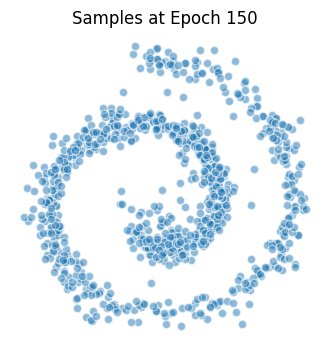

Epoch 150, Loss: 0.8842269778251648
Epoch 151, Loss: 0.6257064938545227
Epoch 152, Loss: 0.8220773935317993
Epoch 153, Loss: 0.6719154715538025
Epoch 154, Loss: 0.8706259727478027
Epoch 155, Loss: 0.9546834230422974
Epoch 156, Loss: 0.7673979997634888
Epoch 157, Loss: 0.5781111717224121
Epoch 158, Loss: 0.6558405160903931
Epoch 159, Loss: 0.7628726363182068
Epoch 160, Loss: 0.7584430575370789
Epoch 161, Loss: 0.5497115850448608
Epoch 162, Loss: 0.8059147000312805
Epoch 163, Loss: 0.8020185232162476
Epoch 164, Loss: 0.798201858997345
Epoch 165, Loss: 0.6130644679069519
Epoch 166, Loss: 0.826278805732727
Epoch 167, Loss: 0.8780414462089539
Epoch 168, Loss: 0.8005326986312866
Epoch 169, Loss: 0.7418782114982605
Epoch 170, Loss: 0.8515304327011108
Epoch 171, Loss: 0.7631558775901794
Epoch 172, Loss: 0.9241065979003906
Epoch 173, Loss: 0.6086901426315308
Epoch 174, Loss: 0.6927553415298462
Epoch 175, Loss: 0.6699386835098267
Epoch 176, Loss: 0.8902077674865723
Epoch 177, Loss: 0.71838784217

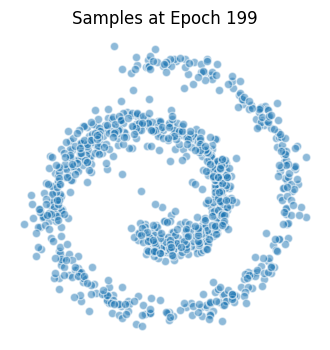

Epoch 199, Loss: 0.9071332812309265


In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

sampler = Sampler(diff_ds, None, None)
nsamples = 1000
dim = 2

n_epochs = 200
for epoch in range(n_epochs):
    epoch_loss = 0
    for xt, t, eps in diff_dl:
        t = t.to(torch.float32)
        xt = xt.to(torch.float32)  # Noised data
        eps = eps.to(torch.float32)  # Actual noise

        optimizer.zero_grad()
        predicted_noise = model(xt, t)
        loss = loss_fn(predicted_noise, eps)
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0 or epoch == n_epochs - 1:
        # Plot samples
        ddpm_samples = sampler.DDPMSampling(model, nsamples, dim)
        plot_samples(ddpm_samples, epoch)

    print(f"Epoch {epoch}, Loss: {loss.item()}")

In [14]:
ddpm_samples = sampler.DDPMSampling(model, nsamples, dim)

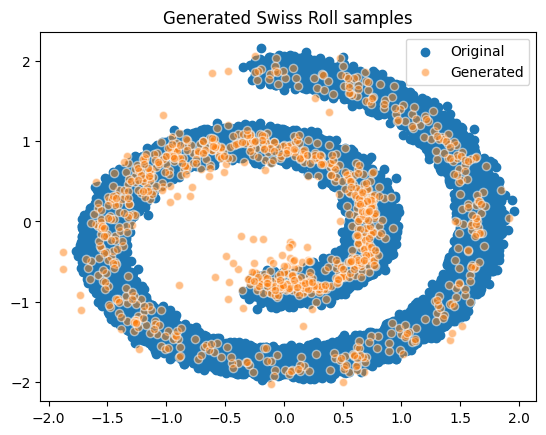

In [15]:
# Visualization of the generated samples
plt.scatter(x[:, 0], x[:, 1])
sns.scatterplot(
    x=ddpm_samples[:, 0].detach().numpy(),
    y=ddpm_samples[:, 1].detach().numpy(),
    alpha=0.5,
    edgecolor="white",
    linewidth=1,
)
plt.legend(["Original", "Generated"])
plt.title("Generated Swiss Roll samples")
plt.show()